# TP 3: Bagging and Random Forests

## 1. Model Aggregation

### Math question:

We know that each independant binary classifier follows a Beroulli distribution with $p>0.5$. <br>Then, as the aggregation og models is a discrete probability distribution sequence of $n$ independent experiments, so it follows a Binomial distribution, with the mean $Lp$, variance $Lp(1-p)$

### 1) the probability of correct prediction for the aggregation of models

In [28]:
from scipy.stats import binom
L = 10
p = 0.7
rv = binom(L, p)

print("the probability of correct prediction is", 1 - rv.cdf(0.5))

the probability of correct prediction is 0.9999940951


We can see that after the aggregation of models, the accuracy is very high.

## 2. Bagging

### 1) Use Bagging with first decision trees of depth 1 (called stumps) and then with decision trees characterized by a greater depth.

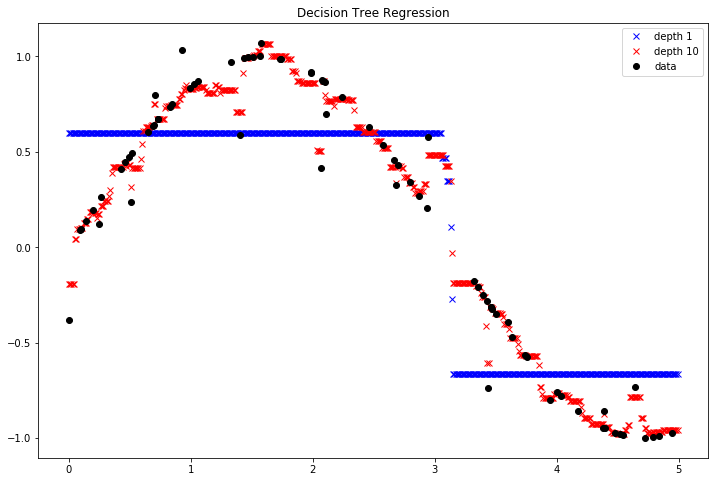

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))

#define the regressor by bagging stumps 
tree_max_depth = 1
tree1 = DecisionTreeRegressor(max_depth=1)
bagging1 = BaggingRegressor(tree1, bootstrap = True)
bagging1.fit(X, y)
tree_max_depth = 10
tree2 = DecisionTreeRegressor(max_depth=10)
bagging2 = BaggingRegressor(tree2, bootstrap = True)
bagging2.fit(X, y)

#Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_stump = bagging1.predict(X_test)
y_deep = bagging2.predict(X_test)

#Plot the results
plt.figure(figsize=(12, 8))
plt.plot(X_test, y_stump, 'x', c="blue", label="depth 1")
plt.plot(X_test, y_deep, 'x', c="red", label="depth 10")
plt.plot(X, y, 'o', c="k", label="data")
plt.title("Decision Tree Regression")
plt.legend(loc=1, numpoints=1)
plt.show()

We can see that we get a way better performance after we have a greater depth.

### 2) Graphically illustrate the roles of L and of the tree depth (max_depth).

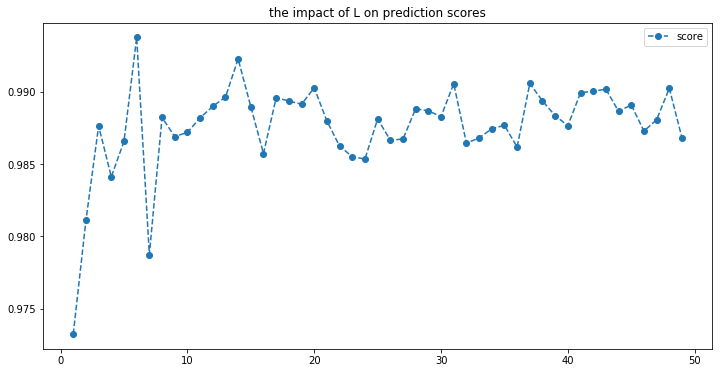

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scoresNestimators = []
nEstimators = range(1, 50, 1)

for n in nEstimators:
    tree = DecisionTreeRegressor()
    tree.fit(X, y)
    bagging = BaggingRegressor(tree, n_estimators=n, bootstrap = True)
    bagging.fit(X, y)
    scoresNestimators.append(bagging.score(X_test,y_test))
    

plt.figure(figsize=(12,6))
plt.plot(range(1, 50, 1), scoresNestimators, 'o', label="score", linestyle='dashed')
plt.title("the impact of L on prediction scores")
plt.legend(loc='best')
plt.show()

We can see that the score gets higher as we have a larger L (number of estimators).

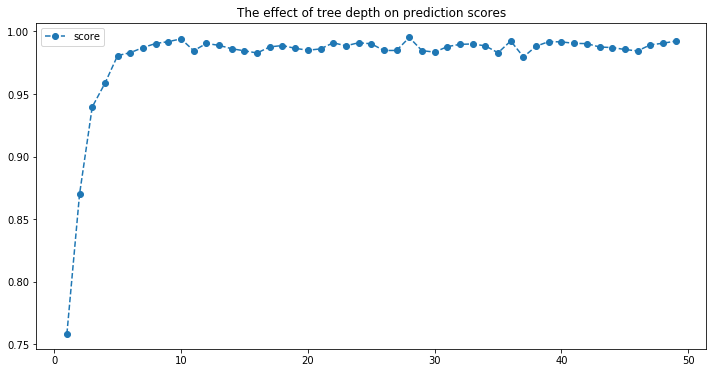

In [7]:

depths = range(1, 50, 1)
scoresDepths = []
scoresNestimators = []

for d in depths:
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X, y)
    bagging = BaggingRegressor(tree, bootstrap = True)
    bagging.fit(X, y)
    scoresDepths.append(bagging.score(X_test,y_test))
    

plt.figure(figsize=(12,6))
plt.plot(range(1, 50, 1), scoresDepths, 'o', label="score", linestyle='dashed')

plt.title("The effect of tree depth on prediction scores")
plt.legend(loc='best')
plt.show()

It can be seen that as the depth auguments, the score also auguments, but the performance gets stable after a certain depth.

### 3) Check that the estimators computed with the decision trees are biased and that the ones based on bagging reduce the variance

We can see on the first graphs that levels are created in the prediction of trees. These bearings can be strongly influenced by outliers (especially for max_depth values which are not too small). The bootstrap estimator will average these errors and thus reduce the variance.

### 4) Playing with the noise level, show the over-fitting (sur-apprentissage).

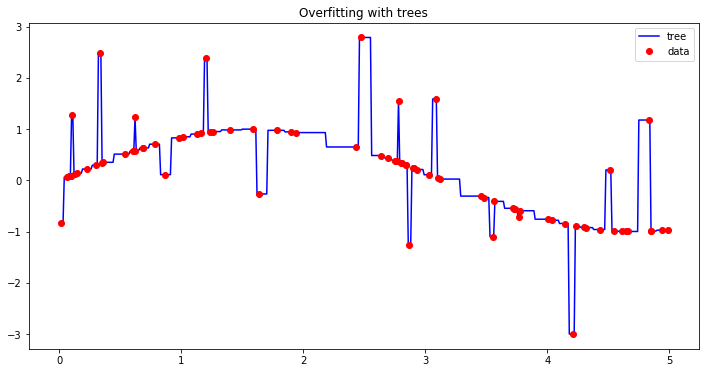

In [9]:
#Add noise for each five data points
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 5 * (0.5 - rng.rand(16))


tree = DecisionTreeRegressor()
tree.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, y_tree, c="blue", label="tree", linestyle = 'solid')
plt.plot(X, y, 'o', c="red", label="data")
plt.title("Overfitting with trees")
plt.legend(loc=1, numpoints=1)
plt.show()

We can clearly see that there is a overfitting with a high noise level.

### 5) Show that we can reduce this phenomenon by randomly sub-sampling (sous-échantillonner) without replacement instead than taking the bootstrap samples.

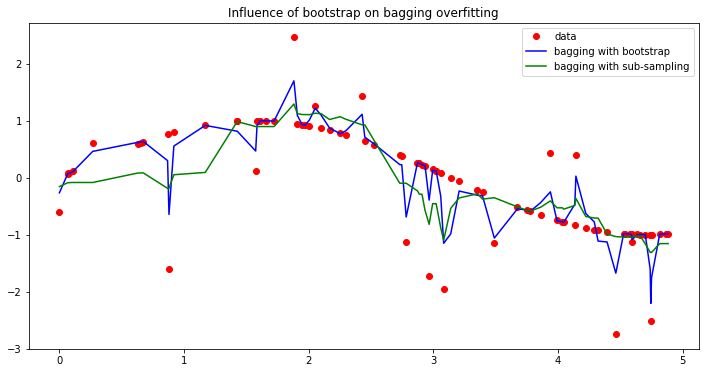

In [10]:
#Get the tree
tree = DecisionTreeRegressor()

x = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(x).ravel()
y[::5] += 5 * (0.5 - rng.rand(16))

plt.figure(figsize=(12, 6))
# plot of the bagging prediction with boostrap
bagging = BaggingRegressor(tree)
bagging.fit(x, y)
y_bagging = bagging.predict(x)
plt.plot(x, y, 'o', c="red", label="data")
plt.plot(x, y_bagging, c="blue", label="bagging with bootstrap")
# plot of the bagging prediction without boostrap but with random sub-sampling
bagging = BaggingRegressor(tree, bootstrap=False, max_samples=0.2)
bagging.fit(x, y)
y_bagging = bagging.predict(x)
plt.plot(x, y_bagging, c="green", label="bagging with sub-sampling")

plt.title("Influence of bootstrap on bagging overfitting")
plt.legend(loc=1, numpoints=1)

We can clearly see form the graph above that sub-sampling has better reduced the over-fitting than bootstrap.

## Random Forest

### 6) Evaluate the scores using Random Forests with a 7-fold cross-validation on the data-sets boston, diabetes, iris and digits. Compare the performances with the ones of a linear SVM.

In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_diabetes
from sklearn.svm import SVC, SVR
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [13]:
# loading the four datasets
boston = load_boston()
diabetes = load_diabetes()
iris = load_iris()
digits = load_digits()

datasets = [boston, diabetes, iris, digits]
ds_names = ["Boston", "Diabetes", "Iris", "Digits"]

# loop on the datasets
for i, ds in enumerate(datasets):
    x, y = ds.data, ds.target
    # check if we have a regression or a classification problem
    if i <= 1:
        rf = RandomForestRegressor()
        svc = SVR(kernel="linear")
    else:
        rf = RandomForestClassifier()
        svc = SVC(kernel="linear")
    # calculate scores
    score_rf = np.mean(cross_val_score(rf, x, y, cv=7))
    score_svc = np.mean(cross_val_score(svc, x, y, cv=7))
    print(ds_names[i], "Random Forest: ", score_rf, "SVC: ", score_svc)

Boston Random Forest:  0.5880916957299668 SVC:  0.5111334854284131
Diabetes Random Forest:  0.343606170364552 SVC:  -0.028076437024497993
Iris Random Forest:  0.9668367346938777 SVC:  0.9736394557823129
Digits Random Forest:  0.896557206334086 SVC:  0.9493286226010172


### 7) Using the dataset iris, limited to the first two variables/features, show the prediction probabilities for each class.

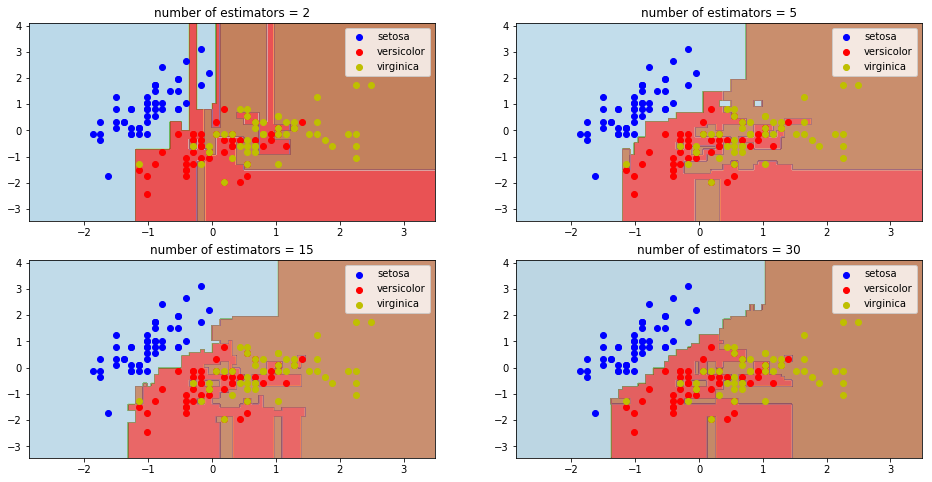

In [14]:
#vary the nuber of random trees
n_estimators = [2, 5, 15, 30]
plot_colors = "bry"
plot_step = 0.02

x_unscaled, y = iris.data[:, :2], iris.target
# Standardize
x = preprocessing.scale(x_unscaled)
# RF fitting

n_lines = 2
n_cols = 2

plt.figure(figsize=(16, 8))
for i, n in enumerate(n_estimators):
    model = RandomForestClassifier(n_estimators=n)
    clf = model.fit(x, y)
    # Plot the decision boundary
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    plt.subplot(n_lines, n_cols, i + 1)
    for tree in model.estimators_:
        # TODO use predict to obtain the probabilities you will store in Z
        # Z = build_z(tree, xx, yy)
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=1. / n, cmap=plt.cm.Paired)
        plt.axis("tight")

        # Plot the training points
    for i, c in zip(range(3), plot_colors):
        idx = np.where(y == i)
        plt.scatter(x[idx, 0], x[idx, 1], c=c, label=iris.target_names[i], cmap=plt.cm.Paired)
    plt.legend(scatterpoints=1)
    plt.title("number of estimators = " + str(n))

plt.show()

### 8) Compare the scores between Random Forests with a 6-fold cross-validation and the pure decision trees.

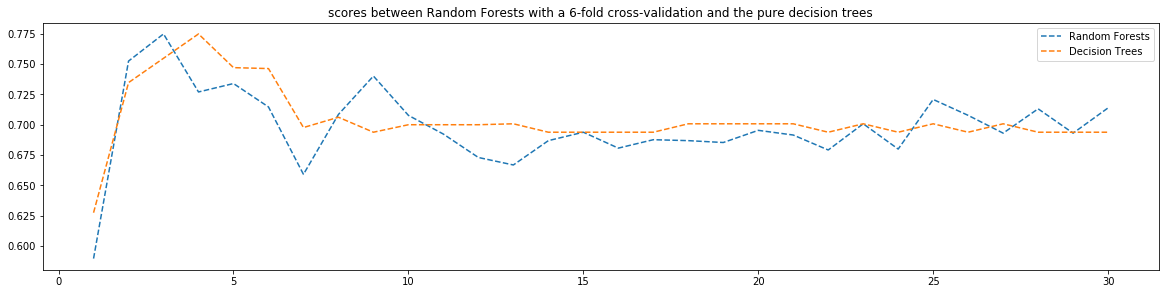

In [18]:
from sklearn.tree import DecisionTreeClassifier
depths = range(1, 31, 1)
iris = load_iris()

X  = preprocessing.StandardScaler().fit_transform(iris.data[:,:2])
y = iris.target
rfscores = []
dtscores = []

for d in depths :
    rfc = RandomForestClassifier(max_depth = d)
    dt  = DecisionTreeClassifier(max_depth = d)
    rfscores.append(np.mean(cross_val_score(rfc, X, y, cv = 6)))
    dtscores.append(np.mean(cross_val_score(dt, X, y, cv = 6)))

    
plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
plt.plot(range(1,31,1), rfscores, label="Random Forests", linestyle='dashed')
plt.plot(range(1,31,1), dtscores, label="Decision Trees", linestyle='dashed')
plt.title("Scores between Random Forests with a 6-fold cross-validation and the pure decision trees")
plt.legend(loc='best')
plt.show()

We can see that both Random Forests and decision trees reduce the over-fitting.

## Comparison of *Random Forests* with *Extra random trees*

### 9) Using boston (regression) and iris (classification, limited to the first two variables/features) datasets, compare the performance of Extra random trees with Random Forest using 5-fold crossvalidation.

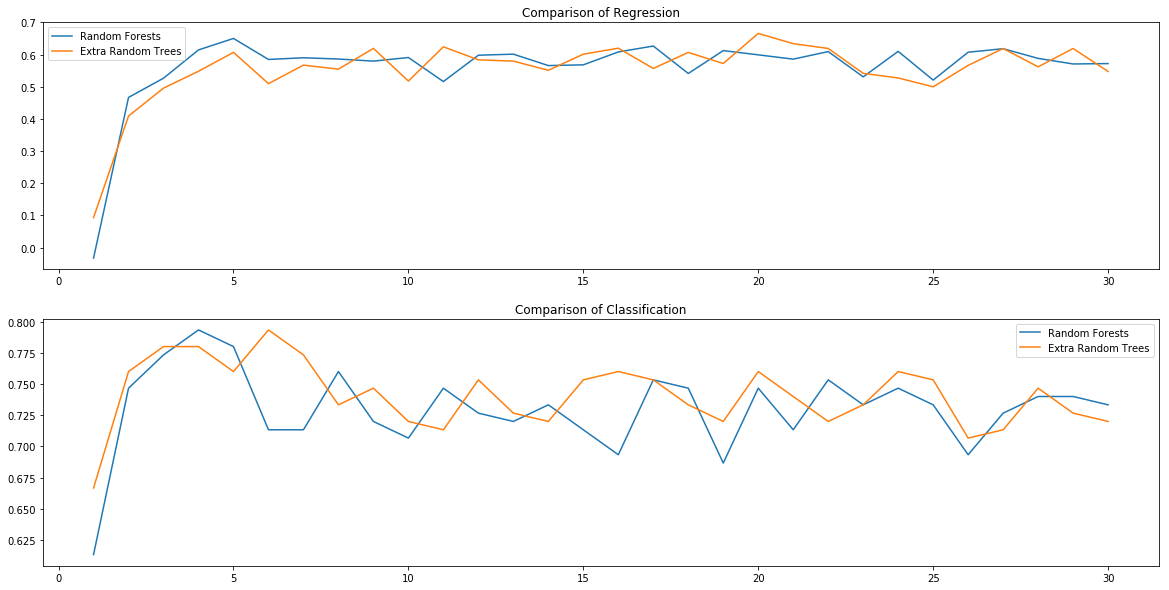

In [23]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

depths = range(1, 31, 1)
iris = load_iris()

X  = preprocessing.StandardScaler().fit_transform(iris.data[:,:2])
y = iris.target
rfcscores = []
etcscores = []

for d in depths :
    rfc = RandomForestClassifier(max_depth = d)
    etc  = ExtraTreesClassifier(max_depth = d)
    rfcscores.append(np.mean(cross_val_score(rfc, X, y, cv = 5)))
    etcscores.append(np.mean(cross_val_score(etc, X, y, cv = 5)))
    
boston = load_boston()

X = boston.data
y = boston.target
rfrscores = []
etrscores = []

for d in depths :
    rfr = RandomForestRegressor(max_depth = d)
    etr  = ExtraTreesRegressor(max_depth = d)
    rfrscores.append(np.mean(cross_val_score(rfr, X, y, cv = 5)))
    etrscores.append(np.mean(cross_val_score(etr, X, y, cv = 5)))

plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(range(1,31,1), rfrscores, label="Random Forests")
plt.plot(range(1,31,1), etrscores, label="Extra Random Trees")
plt.title("Comparison of Regression")
plt.legend(loc='best')
plt.subplot(2, 1, 2)
plt.plot(range(1,31,1), rfcscores, label="Random Forests")
plt.plot(range(1,31,1), etcscores, label="Extra Random Trees")
plt.title("Comparison of Classification")
plt.legend(loc='best')
plt.show()


We can see that they have similar performances.

### 10) Plot the feature importance on both algorithms with **iris** dataset.

Text(0.5,1,'Feature importances of $Extra$ $Random$ $Trees$')

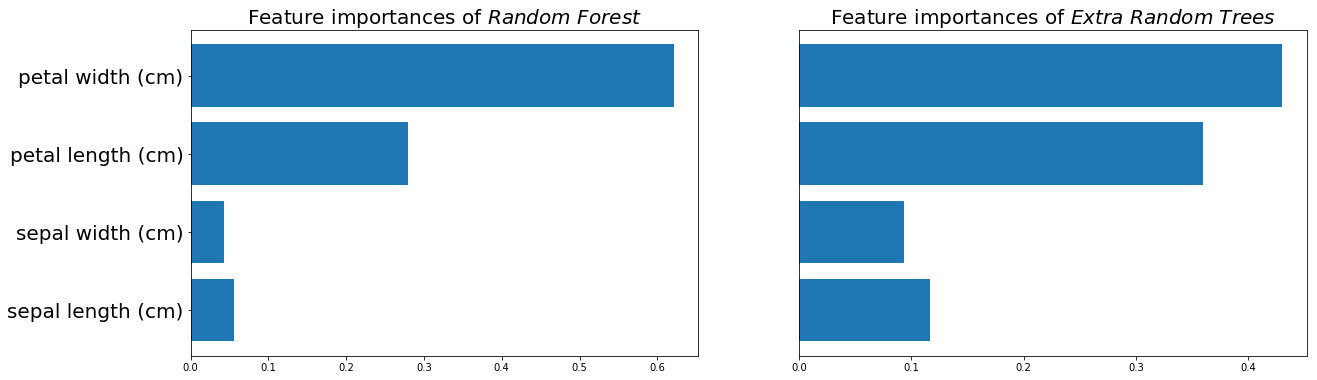

In [59]:
from matplotlib import pyplot

rfc = RandomForestClassifier()
etc  = ExtraTreesClassifier()

iris = load_iris()
X = iris.data
y= iris.target

rfc.fit(X, y)
etc.fit(X, y)

features = iris['feature_names']
rfc_importances = rfc.feature_importances_
etc_importances = etc.feature_importances_
indices = [0, 1, 2, 3]

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.barh(range(len(indices)), rfc_importances[indices] , align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize = 20)
plt.title("Feature importances of $Random$ $Forest$", fontsize = 20)
plt.subplot(1, 2, 2)
plt.barh(range(len(indices)), etc_importances[indices] , align='center')
plt.yticks([])
plt.title("Feature importances of $Extra$ $Random$ $Trees$", fontsize = 20)

Yes, We can observe a difference in feature importances. <br>
This is because that instead of computing the locally optimal feature/split combination (for the random forest), for each feature under consideration, a random value is selected for the split (for the extra random trees). And because of this random selection, we get a different feature importance.